## Libraries

In [55]:
import numpy as np
import pandas as pd

import geopandas as gpd
import matplotlib.pyplot as plt

import esda
import libpysal as lp
import spreg
import folium


from libpysal.weights import KNN
from spreg import GM_Lag, GM_Error
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from spreg import ML_Lag
from mgwr.utils import shift_colormap
from shapely.geometry import Point
from scipy.stats import gaussian_kde

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

In [56]:
df = pd.read_csv('FloodPrediction.csv')
df.head()

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sl                 20544 non-null  int64  
 1   Station_Names      20544 non-null  object 
 2   Year               20544 non-null  int64  
 3   Month              20544 non-null  int64  
 4   Max_Temp           20544 non-null  float64
 5   Min_Temp           20544 non-null  float64
 6   Rainfall           20544 non-null  float64
 7   Relative_Humidity  20544 non-null  float64
 8   Wind_Speed         20544 non-null  float64
 9   Cloud_Coverage     20544 non-null  float64
 10  Bright_Sunshine    20544 non-null  float64
 11  Station_Number     20544 non-null  int64  
 12  X_COR              20544 non-null  float64
 13  Y_COR              20544 non-null  float64
 14  LATITUDE           20544 non-null  float64
 15  LONGITUDE          20544 non-null  float64
 16  ALT                205

## Categorical encoding

### Label encoder to Station_Names

In [58]:
# Initialize the LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'PROB_4BAND' column
df['Station_Names'] = le.fit_transform(df['Station_Names'])

# Optional: Get the mapping of labels to their encoded values
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Barisal': 0, 'Bhola': 1, 'Bogra': 2, 'Chandpur': 3, 'Chittagong (City-Ambagan)': 4, 'Chittagong (IAP-Patenga)': 5, 'Comilla': 6, "Cox's Bazar": 7, 'Dhaka': 8, 'Dinajpur': 9, 'Faridpur': 10, 'Feni': 11, 'Hatiya': 12, 'Ishurdi': 13, 'Jessore': 14, 'Khepupara': 15, 'Khulna': 16, 'Kutubdia': 17, 'Madaripur': 18, 'Maijdee Court': 19, 'Mongla': 20, 'Mymensingh': 21, 'Patuakhali': 22, 'Rajshahi': 23, 'Rangamati': 24, 'Rangpur': 25, 'Sandwip': 26, 'Satkhira': 27, 'Sitakunda': 28, 'Srimangal': 29, 'Sylhet': 30, 'Tangail': 31, 'Teknaf': 32}


In [59]:
df.head()

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,0,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,0,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,0,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,0,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,0,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


## Filling missing values

In [60]:
df.isnull().sum()

Sl                       0
Station_Names            0
Year                     0
Month                    0
Max_Temp                 0
Min_Temp                 0
Rainfall                 0
Relative_Humidity        0
Wind_Speed               0
Cloud_Coverage           0
Bright_Sunshine          0
Station_Number           0
X_COR                    0
Y_COR                    0
LATITUDE                 0
LONGITUDE                0
ALT                      0
Period                   0
Flood?               16051
dtype: int64

In [61]:
df['Flood?'] = df['Flood?'].fillna(0)

In [62]:
df.isnull().sum()

Sl                   0
Station_Names        0
Year                 0
Month                0
Max_Temp             0
Min_Temp             0
Rainfall             0
Relative_Humidity    0
Wind_Speed           0
Cloud_Coverage       0
Bright_Sunshine      0
Station_Number       0
X_COR                0
Y_COR                0
LATITUDE             0
LONGITUDE            0
ALT                  0
Period               0
Flood?               0
dtype: int64

In [63]:
print(df['Flood?'].value_counts())

Flood?
0.0    16412
1.0     4132
Name: count, dtype: int64


## Dropping unnecessary column

In [64]:
df= df.drop(['Sl'], axis=1)

### Aggregating Min & Max temperature

In [65]:
# Create 'Temp_Range' by subtracting Min_Temp from Max_Temp
df['Temp_Range'] = df['Max_Temp'] - df['Min_Temp']

# Remove 'Min_Temp' and 'Max_Temp' from the dataset
df = df.drop(columns=['Min_Temp', 'Max_Temp'])

# Now your dataset df has the 'Temp_Range' feature and no longer includes 'Min_Temp' or 'Max_Temp'


In [66]:
df.head()

,Station_Names,Year,Month,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?,Temp_Range
0,0,1949,1,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,0.0,17.1
1,0,1949,2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,0.0,18.7
2,0,1949,3,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,0.0,16.5
3,0,1949,4,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,0.0,10.0
4,0,1949,5,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,0.0,10.6


## Spillover

### Colinearity

In [67]:
# Create a GeoDataFrame with spatial coordinates and set CRS (WGS84 for degrees)
gdf = gpd.GeoDataFrame(df, 
                       geometry=gpd.points_from_xy(df['LONGITUDE'], df['LATITUDE']),
                       crs="EPSG:4326")  # EPSG:4326 is for geographic coordinates (degrees)

# Project to a metric CRS (e.g., UTM) for distance-based spatial calculations like KNN
gdf = gdf.to_crs(epsg=32630)  # UTM Zone 30N, change as per your location's UTM zone

# Prepare independent variables (X) and dependent variable (y)
X = df[['Temp_Range', 'Rainfall', 'Wind_Speed', 'Cloud_Coverage', 'LATITUDE', 'LONGITUDE', 'ALT']].values
y = df['Flood?'].values

# Scale the independent variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Preparing Data

In [68]:
X_df = pd.DataFrame(X_scaled, columns=['Temp_Range', 'Rainfall', 'Wind_Speed', 'Cloud_Coverage', 'LATITUDE', 'LONGITUDE', 'ALT'])
vif = pd.DataFrame()
vif['Variable'] = X_df.columns
vif['VIF'] = [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]

print(vif)


         Variable       VIF
0      Temp_Range  2.732608
1        Rainfall  2.560059
2      Wind_Speed  1.259406
3  Cloud_Coverage  4.287065
4        LATITUDE  2.540357
5       LONGITUDE  1.699935
6             ALT  1.823227


#### Creating weights

In [69]:
# Create a KNN spatial weights matrix with 5 neighbors
w = KNN.from_dataframe(gdf, k=5)
w.transform = 'R'  # Row-standardize the weights matrix

c:\Users\mhrab\AppData\Local\Programs\Python\Python312\Lib\site-packages\libpysal\weights\distance.py:153: UserWarning: The weights matrix is not fully connected: 
 There are 33 disconnected components.
  W.__init__(self, neighbors, id_order=ids, **kwargs)


### Spatial Lag model (SLM)

In [70]:
# Spatial Lag Model
slm_model = GM_Lag(y, X_scaled, w=w, name_y='Flood?', name_x=['Temp_Range', 'Rainfall', 'Wind_Speed', 'Cloud_Coverage', 'LATITUDE', 'LONGITUDE', 'ALT'])
print(slm_model.summary)


REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: SPATIAL TWO STAGE LEAST SQUARES
--------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      Flood?                Number of Observations:       20544
Mean dependent var  :      0.2011                Number of Variables   :           9
S.D. dependent var  :      0.4009                Degrees of Freedom    :       20535
Pseudo R-squared    :      0.5152
Spatial Pseudo R-squared:  0.3926

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.12500         0.00226        55.25663         0.00000
          Temp_Range        -0.02246         0.00333        -6.73859         0.00000
            Rainfall         0.36719      

c:\Users\mhrab\AppData\Local\Programs\Python\Python312\Lib\site-packages\spreg\diagnostics.py:367: RuntimeWarning: invalid value encountered in sqrt
  se_result = np.sqrt(variance)
c:\Users\mhrab\AppData\Local\Programs\Python\Python312\Lib\site-packages\spreg\diagnostics.py:183: RuntimeWarning: invalid value encountered in sqrt
  ) / np.sqrt(variance)


### Spatial Error Model (SEM)

In [71]:
sem_model = GM_Error(y, X_scaled, w=w, name_y='Flood?', name_x=['Temp_Range', 'Rainfall', 'Wind_Speed', 'Cloud_Coverage', 'LATITUDE', 'LONGITUDE', 'ALT'])
print("SEM Model Summary")
print(sem_model.summary)

SEM Model Summary
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: GM SPATIALLY WEIGHTED LEAST SQUARES
------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :      Flood?                Number of Observations:       20544
Mean dependent var  :      0.2011                Number of Variables   :           8
S.D. dependent var  :      0.4009                Degrees of Freedom    :       20536
Pseudo R-squared    :      0.5992

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CONSTANT         0.19553         0.00239        81.97978         0.00000
          Temp_Range         0.00312         0.00294         1.05950         0.28937
            Rainfall         0.32973         0.002

In [72]:
# Calculate Moran's I
flood_values = gdf['Flood?'].values  # Your dependent variable
moran = esda.Moran(flood_values, w)

# Print the Moran's I value and its p-value
print(f"Moran's I: {moran.I}")
print(f"P-value: {moran.p_sim}")


Moran's I: 0.0502751628622034
P-value: 0.001


## Flood percentage

In [73]:
# Step 1: Group by 'Station_Names' and calculate the flood-prone percentage
# Assuming 'Flood?' is binary (1 for flood, 0 for no flood)
flood_prone_percentage = df.groupby('Station_Names')['Flood?'].mean() * 100

# Step 2: Convert the result to a DataFrame and reset the index
flood_prone_percentage = flood_prone_percentage.reset_index()

# Step 3: Rename the columns for clarity
flood_prone_percentage.columns = ['Station_Names', 'Flood_Prone_Percentage']

# Step 4: Sort by 'Station_Names' in ascending order (since they are label encoded)
flood_prone_percentage = flood_prone_percentage.sort_values(by='Station_Names')

# Step 5: View the results
print(flood_prone_percentage)



    Station_Names  Flood_Prone_Percentage
0               0               30.128205
1               1               18.055556
2               2               13.510101
3               3               21.666667
4               4               31.250000
5               5               25.769231
6               6               18.434343
7               7               29.797980
8               8                1.366120
9               9               39.267677
10             10               10.984848
11             11               28.455285
12             12               32.118056
13             13                7.075472
14             14                8.459596
15             15               23.750000
16             16               11.742424
17             17               25.675676
18             18               13.063063
19             19               30.820106
20             20               20.333333
21             21               15.530303
22             22               23

## Mapping

### Loading Shapefiles (GeoPandas needed)

In [74]:
shapefile_path = 'ShapeFiles/elev8bg.shp'
gdf_map = gpd.read_file(shapefile_path)

### Plotting the map

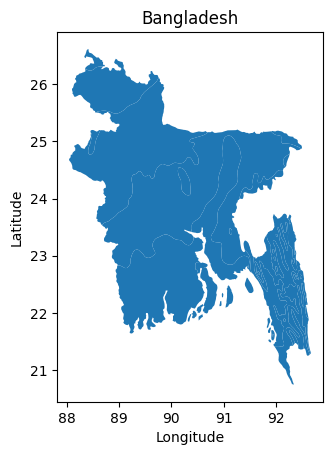

In [75]:
gdf_map.plot()

# Customize and show the plot
plt.title('Bangladesh')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


### Spilliting unique coordinates for each stations

In [76]:
# Step 1: Group by 'Station_Names' and get the unique coordinates for each station
station_coordinates = df.groupby('Station_Names').agg({
    'LONGITUDE': 'first',
    'LATITUDE': 'first',
    'X_COR': 'first',
    'Y_COR': 'first'
}).reset_index()

# Step 2: View the new DataFrame
print(station_coordinates)

    Station_Names  LONGITUDE  LATITUDE      X_COR     Y_COR
0               0    90.3600     22.70  536809.80  510151.9
1               1    90.6600     22.70  567637.60  510271.8
2               2    89.3600     24.88  435303.70  751187.5
3               3    90.6700     23.26  568556.90  571945.8
4               4    91.8166     22.35       0.00       0.0
5               5    91.7900     22.34  684570.90  471415.0
6               6    91.1900     23.48  621445.20  596963.4
7               7    91.9800     21.46  705183.00  374324.6
8               8    90.3900     23.78  540098.60  629248.4
9               9    88.6600     25.63  365790.20  834718.0
10             10    89.8400     23.61  483877.30  610719.3
11             11    91.3700     23.01  640285.90  544954.5
12             12    91.1300     22.29  616159.20  465295.1
13             13    89.0400     24.12  402483.20  667640.8
14             14    89.2200     23.17  420062.70  562498.8
15             15    90.2200     21.98  

In [77]:
flood_prone_percentage

,Station_Names,Flood_Prone_Percentage
0,0,30.128205
1,1,18.055556
2,2,13.510101
3,3,21.666667
4,4,31.250000
5,5,25.769231
6,6,18.434343
7,7,29.797980
8,8,1.366120
9,9,39.267677


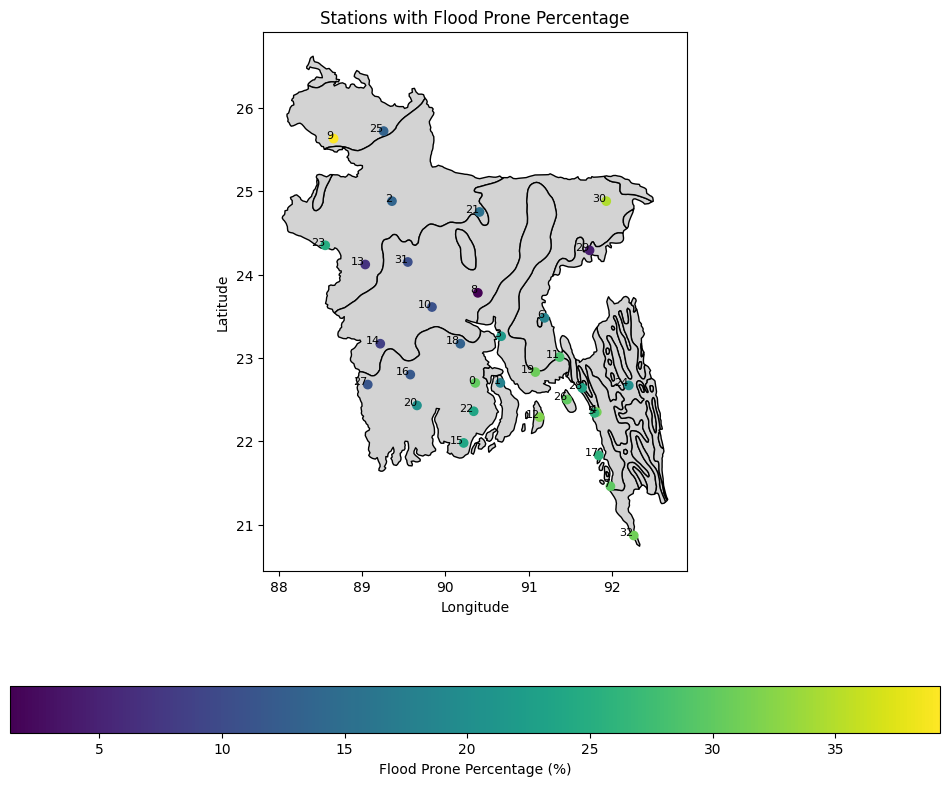

In [51]:
# Assuming 'station_coordinates' and 'flood_prone_percentage' DataFrames are available
# Step 1: Merge flood-prone percentages with station coordinates
merged_df = pd.merge(station_coordinates, flood_prone_percentage, on='Station_Names')

# Step 2: Create a GeoDataFrame with the merged data
gdf_stations = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.LONGITUDE, merged_df.LATITUDE))

# Step 3: Plot the base map
fig, ax = plt.subplots(figsize=(12, 10))
gdf_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Step 4: Plot the stations with flood-prone percentages
gdf_stations.plot(ax=ax, marker='o', cmap='viridis', legend=True,
                   column='Flood_Prone_Percentage', 
                   legend_kwds={'label': "Flood Prone Percentage (%)",
                                'orientation': "horizontal"})

# Optional: Add labels to the points for clarity
for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations['Station_Names']):
    ax.text(x, y, label, fontsize=8, ha='right')

# Plot details
ax.set_title('Stations with Flood Prone Percentage')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

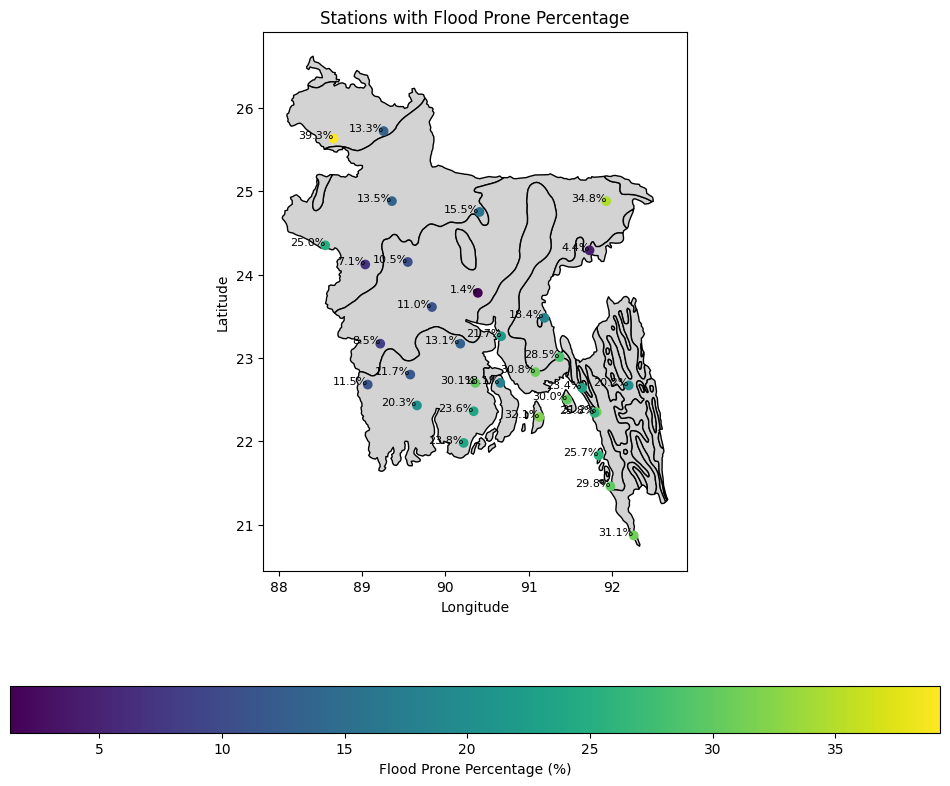

In [52]:
# Assuming 'station_coordinates' and 'flood_prone_percentage' DataFrames are available
# Step 1: Merge flood-prone percentages with station coordinates
merged_df = pd.merge(station_coordinates, flood_prone_percentage, on='Station_Names')

# Step 2: Create a GeoDataFrame with the merged data
gdf_stations = gpd.GeoDataFrame(merged_df, geometry=gpd.points_from_xy(merged_df.LONGITUDE, merged_df.LATITUDE))

# Step 3: Plot the base map
fig, ax = plt.subplots(figsize=(12, 10))
gdf_map.plot(ax=ax, color='lightgrey', edgecolor='black')

# Step 4: Plot the stations with flood-prone percentages
gdf_stations.plot(ax=ax, marker='o', cmap='viridis', legend=True,
                   column='Flood_Prone_Percentage', 
                   legend_kwds={'label': "Flood Prone Percentage (%)",
                                'orientation': "horizontal"})

# Optional: Add flood-prone percentage labels to the points
for x, y, percentage in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations['Flood_Prone_Percentage']):
    ax.text(x, y, f'{percentage:.1f}%', fontsize=8, ha='right')

# Plot details
ax.set_title('Stations with Flood Prone Percentage')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()


### Interactive heatmap

In [54]:
import folium
from folium.plugins import HeatMap

# Step 1: Merge flood-prone percentages with station coordinates
merged_df = pd.merge(station_coordinates, flood_prone_percentage, on='Station_Names')

# Step 2: Create a folium map centered on Bangladesh (or your area of interest)
map_center = [merged_df['LATITUDE'].mean(), merged_df['LONGITUDE'].mean()]
m = folium.Map(location=map_center, zoom_start=7)

# Step 3: Prepare data for heatmap (latitude, longitude, and flood-prone percentage)
heat_data = [[row['LATITUDE'], row['LONGITUDE'], row['Flood_Prone_Percentage']] for index, row in merged_df.iterrows()]

# Step 4: Create the heatmap layer
HeatMap(heat_data, min_opacity=0.4, radius=15, blur=10, max_zoom=1).add_to(m)

# Step 5: Display the map
m.save('flood_prone_heatmap.html')
m
